# **To Do**

Go to File > Open in playground mode

**!!! Change Runtime to GPU !!!**

**Go to Runtime > Change runtime type > Hardware accelerator:GPU **

To run, go Runtime> Restart and run all

In [ ]:
!git clone https://github.com/twpkevin06222/Liver-Segmentation-Project-.git medical_imaging

Cloning into 'medical_imaging'...
remote: Enumerating objects: 581, done.
remote: Total 581 (delta 0), reused 0 (delta 0), pack-reused 581
Receiving objects: 100% (581/581), 299.41 MiB | 42.58 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [ ]:
!pip install nibabel

# Imports

In [ ]:
import h5py
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading nifti images
import math
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#from read_data import load_images
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## Dependencies

In [ ]:
import tensorflow as tf
import keras
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Tensorflow version: 2.12.0
Keras version: 2.12.0


---

# Data Preprocessing
Prepare data for input and data preprocessing

In [ ]:
def three_to_two(path, label='FALSE'):
    ff = sorted(glob.glob(path))
    images =[]
    for f in range(len(ff)):
        a = nib.load(ff[f])
        a = a.get_data()
        for i in range(a.shape[2]):
            images.append(a[:,:,i])
    images = np.asarray(images)
    #images = images.reshape(-1, 128,128, 1) # dimension to feed into the network
    return images

def min_max_norm(images):
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi)/ (m - mi)
    return images

def label_outliers(img_labels):
    img_labels[img_labels>1]=1
    img_labels[img_labels<0]=0
    return img_labels

#Image for training
images = three_to_two(path='medical_imaging/tmp/tmp_img/img_new/*')
x_data = min_max_norm(images)

#labels
img_labels = three_to_two(path='medical_imaging/tmp/tmp_img/img_new_label/*')
y_data = label_outliers(img_labels)

#Test Image
img_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img/*')
x_test = min_max_norm(img_test)

#Test Labels
label_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img_label/*')
y_test = label_outliers(label_test)

<ipython-input-5-281133919471>:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  a = a.get_data()


In [ ]:
def add_label_noise(labels, noise_ratio=0.50):
    flip_indices = np.random.choice(len(labels), size=int(len(labels) * noise_ratio), replace=False)
    # Flip the labels (0->1 and 1->0)
    labels[flip_indices] = 1 - labels[flip_indices]
    return labels

# Adding 1% noise to the training labels
y_data_noisy = add_label_noise(y_data.copy())  # Use .copy() to avoid modifying original y_data

# Now you can call the custom_augmentation function with the noisy labels (y_data_noisy) and x_data


Plot data w.r.t labels

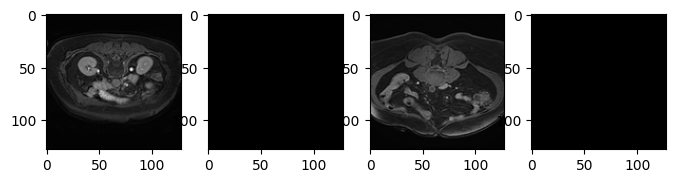

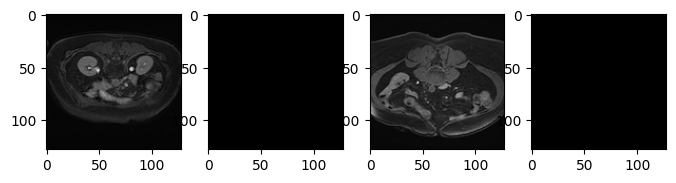

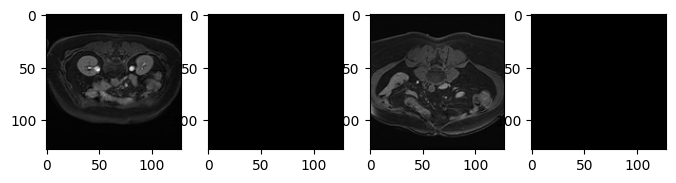

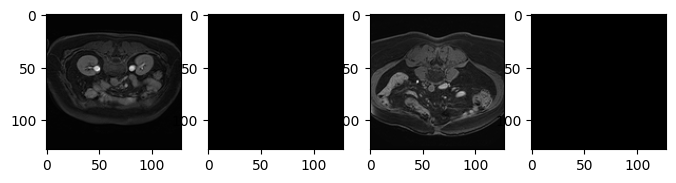

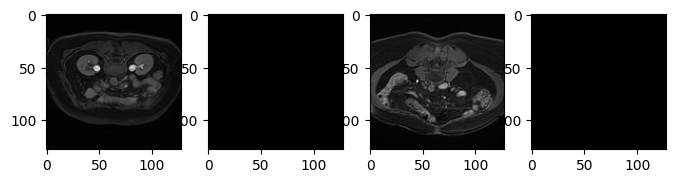

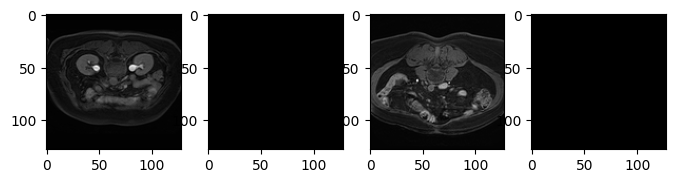

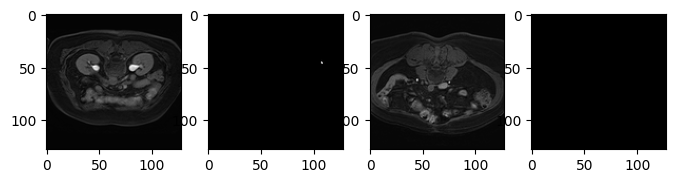

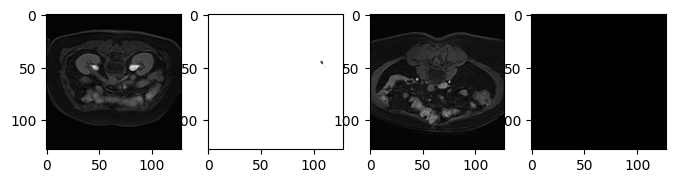

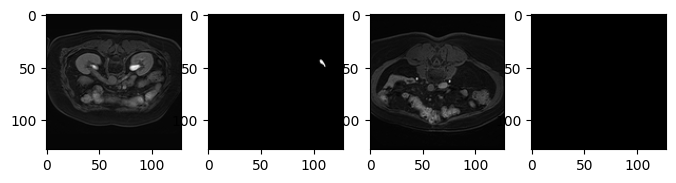

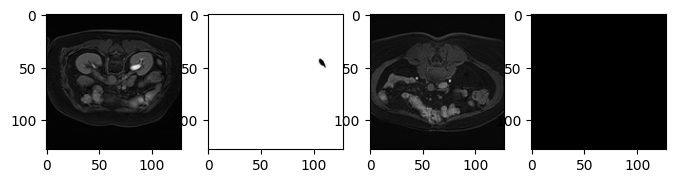

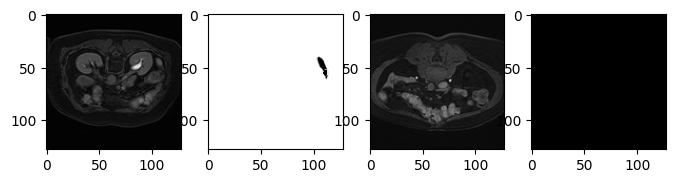

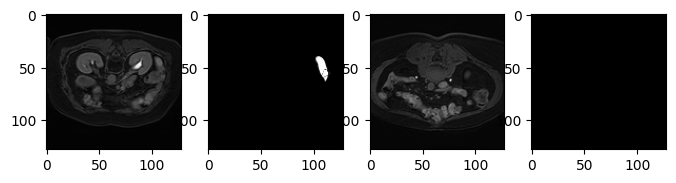

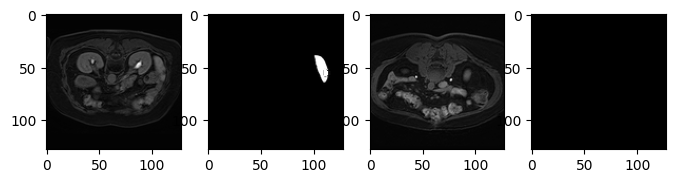

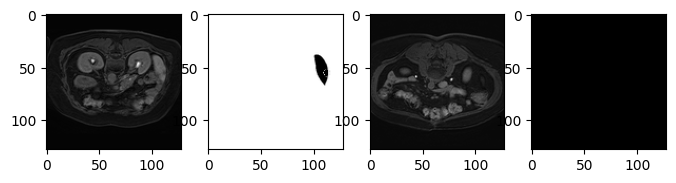

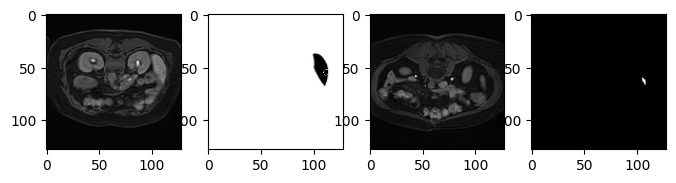

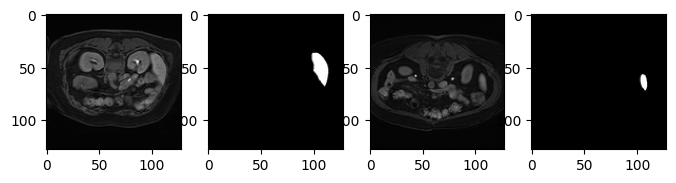

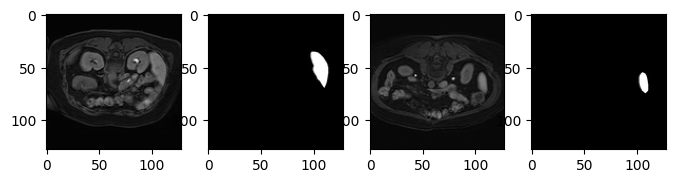

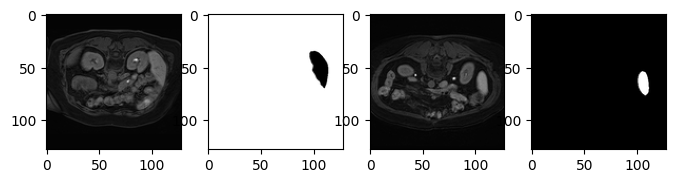

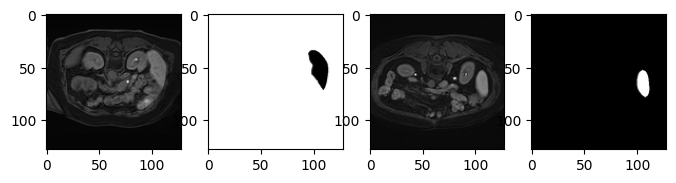

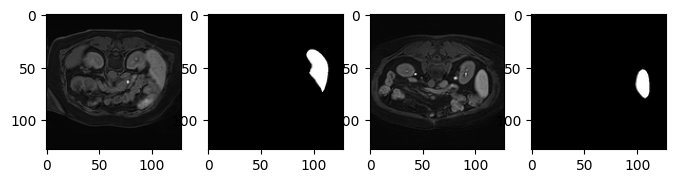

In [ ]:
#show 1st 20 slices

for i in range(20):
    fig, ax = plt.subplots(1,4, figsize = (8,4))
    ax[0].imshow(x_data[i], cmap='gray')
    ax[1].imshow(y_data_noisy[i], cmap='gray')
    ax[2].imshow(x_test[i], cmap='gray')
    ax[3].imshow(y_test[i], cmap='gray')

plt.show()

Reshape input data to feed into the network with
shape (depth*#image, width, height, channel)

In [ ]:
x_data = x_data[:,:,:,np.newaxis] # same as reshape (-1,128,128,1)
y_data_noisy = y_data_noisy[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]
y_test = y_test[:,:,:,np.newaxis]

print('Dimension for training data:', x_data.shape)
print('Dimension for training data labels:', y_data_noisy.shape)
print('Dimension for test data:', x_test.shape)
print('Dimension for test data labels:', y_test.shape)

Dimension for training data: (3036, 128, 128, 1)
Dimension for training data labels: (3036, 128, 128, 1)
Dimension for test data: (735, 128, 128, 1)
Dimension for test data labels: (735, 128, 128, 1)


Split data: 80% Training, 20% Validation

In [ ]:
from sklearn.utils import shuffle

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data_noisy, test_size = 0.2, random_state =42)
x_test, y_test = shuffle(x_test, y_test, random_state= 42)

Approximation of Dice Coefficient

In [ ]:
import tensorflow as tf
from keras import backend as K
def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def hausdorff_distance(y_true, y_pred):
    surface_distances = tf.reduce_sum(y_true * y_pred, axis=[1, 2]) / tf.reduce_sum(y_true + y_pred, axis=[1, 2])
    hausdorff_distance = tf.reduce_max(surface_distances)
    return hausdorff_distance

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    total_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (total_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def log_cosh_dice_loss(y_true, y_pred):
    x = dice_loss(y_true, y_pred)
    return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

In [ ]:
input_layer = Input(shape=x_train.shape[1:]) #Input(shape = (x, y, inChannel))

---

# Network Topology

Toy Model 01

In [ ]:
def conv_block(x_in, filters, batch_norm, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x

def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_block(u, filters, batch_norm)
    merge=concatenate([merge, conv],axis=-1)
    return merge

def Unet_01(input_layer):
    conv1 = conv_block(input_layer, filters=16, batch_norm='TRUE')
    pool1 = pool(conv1)

    conv2 = conv_block(pool1, filters=32, batch_norm='TRUE')
    pool2 = pool(conv2)

    conv3 = conv_block(pool2, filters=32, batch_norm='TRUE')
    pool3 = pool(conv3)

    conv4 = conv_block(pool3, filters=64, batch_norm='TRUE')
    pool4 = pool(conv4)

    conv5 = conv_2d(pool4, filters=128, batch_norm='TRUE')

    up1 = up(conv5,filters=128, merge=conv4, batch_norm='TRUE')
    conv6 = conv_2d(up1, filters=128, batch_norm='TRUE')

    up2 = up(conv6, filters=128, merge=conv3, batch_norm='TRUE')
    conv7 = conv_2d(up2, filters=128, batch_norm='TRUE')

    up3 = up(conv7, filters=64, merge=conv2, batch_norm='TRUE')
    conv8 = conv_2d(up3, filters=64, batch_norm='TRUE')

    up4 = up(conv8, filters=32, merge=conv1, batch_norm='TRUE')
    conv9 = conv_2d(up4, filters=32, batch_norm='TRUE')

    conv10 = conv_2d(conv9, filters=1, batch_norm='FALSE', acti='sigmoid')

    output_layer = conv10
    model = Model(input_layer, output_layer)

    return model


Swtich for different network

In [ ]:
model = Unet_01(input_layer)

Data Augmentation

In [ ]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

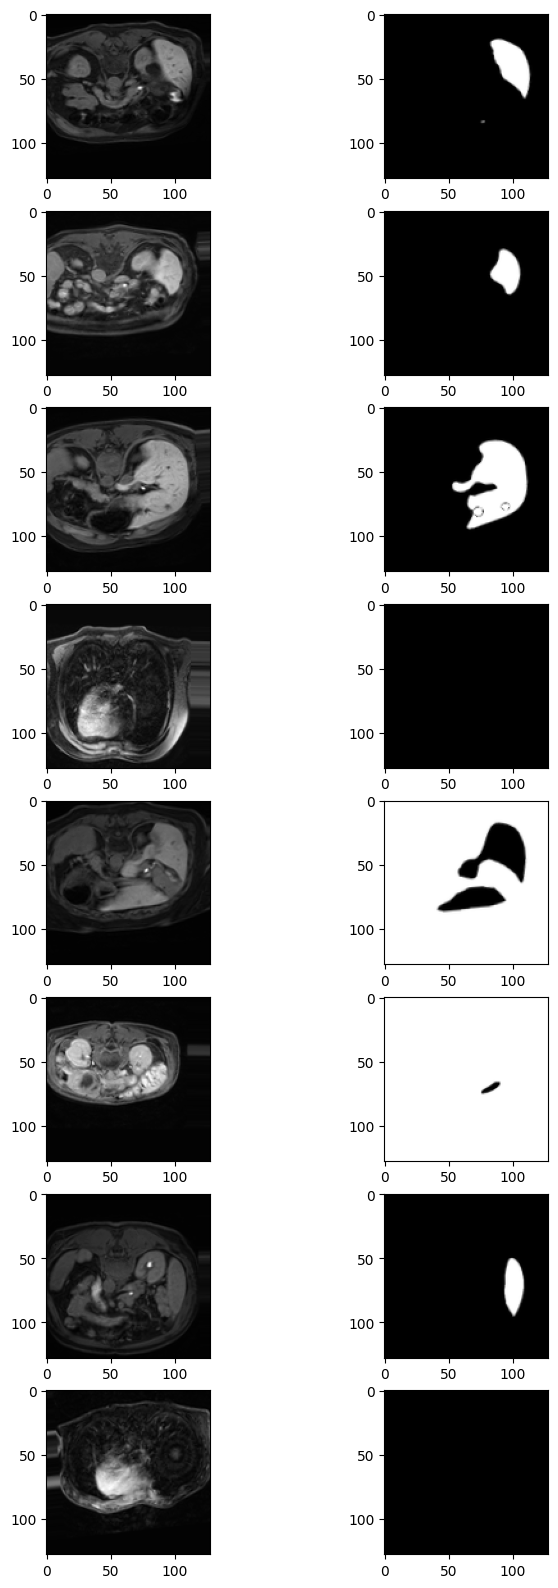

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap='gray')
plt.show()

In [ ]:
model.compile(optimizer=Adam(1e-4), loss= log_cosh_dice_loss, metrics=[dice_coef,jaccard_index,hausdorff_distance,precision,specificity,sensitivity])

Parameters

In [ ]:
# def steps_per_epoch(sample, batch_size):
#     a = int(np.floor(sample/batch_size))
#     if a<200:
#         return 200
#     else:
#         return a

sample = len(x_data)
batch_size = 64
epochs = 20
steps_per_epoch = 200
#steps_per_epoch = int(np.floor(sample/batch_size))
#steps_per_epoch = steps_per_epoch(sample, batch_size)

print('Step per epoch: ', steps_per_epoch)

Step per epoch:  200


Set checkpoint

In [ ]:
from keras.callbacks import LearningRateScheduler
weight_saver = ModelCheckpoint('seg.h5', monitor='val_dice_coef',
                                              save_best_only=True, save_weights_only=True)

lr_decay = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [ ]:
from keras.callbacks import TensorBoard
import time

model_dir = 'logs/{}'.format(time.strftime("%H"+"%M"))
tensorboard = TensorBoard(log_dir= model_dir, histogram_freq=epochs, batch_size=batch_size, write_graph=True,
                          write_grads=False, write_images=True, embeddings_freq=0,
                          embeddings_layer_names=None, embeddings_metadata=None,
                          embeddings_data=None, update_freq='epoch')

write_time = time.strftime("%H"+"%M")

---

In [ ]:
!/opt/bin/nvidia-smi

Sun Aug 27 12:31:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |    401MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Training

In [ ]:
hist = model.fit_generator(my_generator(x_train, y_train, batch_size),
                           steps_per_epoch = steps_per_epoch,
                           validation_data = (x_val, y_val),
                           epochs=epochs, verbose=1,
                           callbacks = [weight_saver, lr_decay])

<ipython-input-21-714d6c19448a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(my_generator(x_train, y_train, batch_size),


Epoch 1/20
200/200 [==============================] - 105s 404ms/step - loss: 0.0584 - dice_coef: 0.6587 - jaccard_index: 0.4934 - hausdorff_distance: 0.4893 - precision: 0.5058 - specificity: 0.0127 - sensitivity: 0.9865 - val_loss: 0.0694 - val_dice_coef: 0.6330 - val_jaccard_index: 0.4692 - val_hausdorff_distance: 0.4979 - val_precision: 0.4711 - val_specificity: 0.0000e+00 - val_sensitivity: 0.9999 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 68s 341ms/step - loss: 0.0542 - dice_coef: 0.6715 - jaccard_index: 0.5078 - hausdorff_distance: 0.4994 - precision: 0.5084 - specificity: 4.6943e-07 - sensitivity: 1.0000 - val_loss: 0.0689 - val_dice_coef: 0.6344 - val_jaccard_index: 0.4708 - val_hausdorff_distance: 0.4996 - val_precision: 0.4711 - val_specificity: 0.0000e+00 - val_sensitivity: 1.0000 - lr: 8.0000e-04
Epoch 3/20
200/200 [==============================] - 68s 341ms/step - loss: 0.0543 - dice_coef: 0.6707 - jaccard_index: 0.5063 - hausdorff_distance: 0.499

In [ ]:
model.load_weights('seg.h5')

---

# Results  

Learning Rate Plot

In [ ]:
plt.plot(hist.history['lr'], color='b')
plt.xlabel("epochs")
plt.ylabel("Learning Rate")
plt.grid(linestyle='dotted')
plt.show()

***

Loss and Dice Coefficient Plot

In [ ]:
plt.plot(hist.history['loss'], color='b', label='Training')
plt.plot(hist.history['val_loss'], color='r', label='Validation')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid(linestyle='dotted')
plt.show()

import matplotlib.pyplot as plt

# Assuming you have a `hist` dictionary with metrics like 'loss', 'val_loss', 'dice_coef', 'val_dice_coef',
# 'specificity', 'val_specificity', 'sensitivity', 'val_sensitivity', 'precision', 'val_precision',
# 'jaccard_index', 'val_jaccard_index', 'hausdorff_distance', 'val_hausdorff_distance', etc.

# Plot all metrics in one graph
plt.figure(figsize=(12, 8))

# Dice Coefficient
plt.plot(hist.history['dice_coef'], color='b', label='Training Dice Coefficient')
plt.plot(hist.history['val_dice_coef'], color='r', label='Validation Dice Coefficient')

# Specificity
plt.plot(hist.history['specificity'], color='g', label='Training Specificity')
plt.plot(hist.history['val_specificity'], color='m', label='Validation Specificity')

# Sensitivity (Recall)
plt.plot(hist.history['sensitivity'], color='c', label='Training Sensitivity')
plt.plot(hist.history['val_sensitivity'], color='y', label='Validation Sensitivity')

# Precision
plt.plot(hist.history['precision'], color='k', label='Training Precision')
plt.plot(hist.history['val_precision'], color='purple', label='Validation Precision')

# Jaccard Index (Intersection over Union)
plt.plot(hist.history['jaccard_index'], color='orange', label='Training Jaccard Index')
plt.plot(hist.history['val_jaccard_index'], color='pink', label='Validation Jaccard Index')

# Hausdorff Distance
plt.plot(hist.history['hausdorff_distance'], color='darkgreen', label='Training Hausdorff Distance')
plt.plot(hist.history['val_hausdorff_distance'], color='olive', label='Validation Hausdorff Distance')

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend(loc='lower right')
plt.grid(linestyle='dotted')
plt.title("Metrics over Epochs")
plt.show()


In [ ]:
# To run tensorboard
print('To view tensorboard, put this in your command line: \n tensorboard --log=logs/{}/'.format(write_time))

In [ ]:
!rm -rf ngrok-stable-linux-amd64.zip
!rm -rf ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
#!rm -f log/*   # Delete this if you want to keep the logs of the old runs
LOG_DIR = 'logs/{}'.format(write_time)
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
# Assuming you have already trained your model and loaded the test data in `x_test` and `y_test`

# Evaluate the model on the test data
test_eval = model.evaluate(x_test, y_test, verbose=1)

# Extract the test accuracy from the evaluation results
test_accuracy = test_eval[1]

# Print the test accuracy
print('Test accuracy:', test_accuracy)


---

# Prediction

In [ ]:
y_pred = model.predict(x_test)
for i in range(0,20,2):
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].imshow(x_test[i,:,:,0], cmap='gray')
    ax[1].imshow(y_test[i,:,:,0], cmap='viridis')
    ax[2].imshow(y_pred[i,:,:,0], cmap='viridis')
plt.show()

---

# Appendix

In [ ]:
model.summary()

# Reference

*   https://www.kaggle.com/toregil/a-lung-u-net-in-keras
*   https://github.com/jocicmarko/ultrasound-nerve-segmentation

